**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Constant Thermal Conductivity, Constant Source, and Robin BC

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**13 Dec 2024**

---
## Table of Contents<a id = "toc"></a>
* [Problem](#Problem)
  + [Objectives](#Obj)
  + [Data](#Data)
  + [Domain](#Domain) 
* [Test Two](#test)
  + [Results](#Results)
  + [Comparing to Gold Solution](#Comparison)
  + [Comparing to Analytical Solution](#Analytical) 
* [Conclusion](#Conclusion) 
---

## [Problem](#toc)<a id = "Problem"></a>

Find temeprature distrubtion, derive heat flux, employ the Rayleigh-Ritz method 

### [Objective](#toc)<a id = "Data"><br> 

+ Find the temperature distribution *u*(*x*).
+ Determine the heat flux *q*(*x*)=-*ku'*(*x*)
+ Compare the analytical and numerical solutions
+ Compare the numerical solutions to a gold standard solution
+ Interpretation of *u*(*x*) and *q*(*x*)

### [Problem Data](#toc)<a id = 'Data'></a>

> a = 0 cm <br>
> b = 5 cm <br>
> u(a) = 20 C <br>
> u(b) = 40 C <br>
> k = 42 W/(mK) <br>
> f = 206151 W/m^2 

### [Domain](#toc)<a id = "Domain"></a>

In [10]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min=0
x_max=0.05

degree = 2  #Degree of the lagrange polinomials used
n_elem = 10 #Number of elements used

In [11]:
'''Domain partition'''
from pyfires import get_domain_partition
'''Parent mapping'''
from pyfires import get_parent_mapping
'''The basis functions'''
from pyfires import get_parent_basis_functions
'''Again the function for the obtaining of the basis functions'''
from pyfires import global_basis_function
'''All global basis functions'''
from pyfires import get_global_basis_functions
'''Inner product'''
from pyfires import inner_product

In [12]:
'''FEM Solution'''
'''Domain partition'''
domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]


## [Implementing Data](#toc)<a id = "test"></a>

Test two constraints the system with a constant thermal conductivity and a constant heat source using a Robin boundary condition. The goal of simulating the domain with these conditions is to produce a graphical solution on how heat is transfered throughout the domain. 

In [15]:
'''Heat Transfer Coefficient'''
htc = 10      #Heat transfer coefficient

In [16]:
'''Thermal conductivity'''
from pyfires import linear_func
from pyfires import plot_func

k_func = linear_func(x_min, x_max, (42.0, 42.0)) # W/mK

'''Heating Power Density'''
f_func = linear_func(x_min, x_max, (5*206151.0, 5*212621.0)) # W/m^3

view_plots = False

In [17]:
if view_plots:
    n_plot_pts = 200
    title = 'Thermal Conductivity'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'K [W/mk]'
    plot_func(k_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Heating Power Density'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'f [W/m^3]'
    plot_func(f_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [18]:
'''Building the lift function'''
u_a = 20 #temperature at point a in degrees C
u_b = 40 #temperature at point b in degrees C

lift_func = linear_func(x_min, x_max, (u_a, u_b)) # C
lift_prime = (u_b-u_a)/(x_max-x_min)
lift_func_prime = linear_func(x_min, x_max, (lift_prime, lift_prime)) # C

view_plots = False

In [19]:
if view_plots:
    n_plot_pts = 200
    title = 'Lift Function'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'T [C]'
    plot_func(lift_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Lift Function Prime'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'dT/dx [C/m]'
    plot_func(lift_func_prime, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [20]:
'''Build FEM A Matrix'''
from pyfires import build_a_mtrx_2
a_mtrx_2 = build_a_mtrx_2(phi_list, phi_prime_list, k_func, domain_partition, x_min, x_max, n_elem, htc)

In [21]:
'''Build load vector'''
from pyfires import build_b_vec_2

b_vec_2 = build_b_vec_2(phi_list, phi_prime_list, k_func, f_func, lift_func_prime, domain_partition, x_min, x_max, n_elem, htc, u_a, u_b)

### [Results](#toc)<a id = "Results"></a>

In [23]:
'''Solution'''
'''Compute optimal coefficient vector'''
import numpy as np

c_star_vec = np.linalg.solve(a_mtrx_2, b_vec_2)

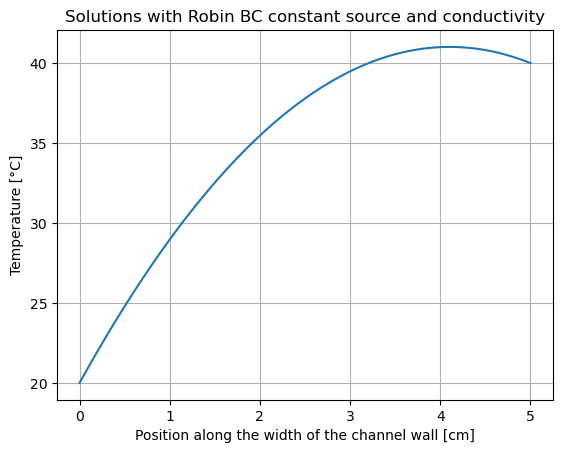

In [24]:
from pyfires import u_star

plot_func(lambda x: u_star(x, phi_list, lift_func, c_star_vec), x_min, x_max, 100,
          x_scale=100,
          title='Solutions with Robin BC constant source and conductivity', 
          xlabel='Position along the width of the channel wall [cm]',
          ylabel='Temperature [°C]')

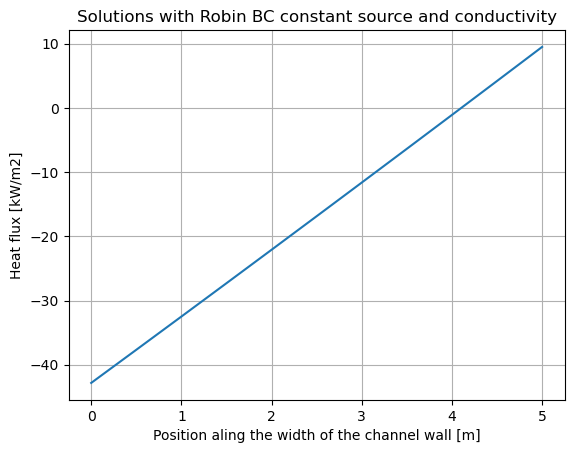

In [25]:
from pyfires import u_star_prime
h_e = (x_max-x_min)/n_elem
q_x = lambda x: - k_func(x) * u_star_prime(x, phi_prime_list, lift_func_prime, c_star_vec, h_e)
plot_func(q_x, x_min, x_max, 100, 
          x_scale=100, y_scale=1/1000,
          title='Solutions with Robin BC constant source and conductivity', 
          xlabel='Position aling the width of the channel wall [m]',
          ylabel='Heat flux [kW/m2]')

In [26]:
'''Normal heat flux at boundaries'''
n_x_a = -1.0
n_x_b =  1.0
print('q_n(a) = ', (q_x(x_min) * n_x_a)/1000)  
print('q_n(b) = ', (q_x(x_max) * n_x_b)/1000)

q_n(a) =  [42.83980625]
q_n(b) =  [9.50669375]


### [Results Comparison with Gold-Data](#toc)<a id = "Comparison"></a>

In [28]:
import numpy as np
(x,u,q) = np.loadtxt('gold-data/01-test-gold.txt')
u_gold = np.column_stack((x,u))

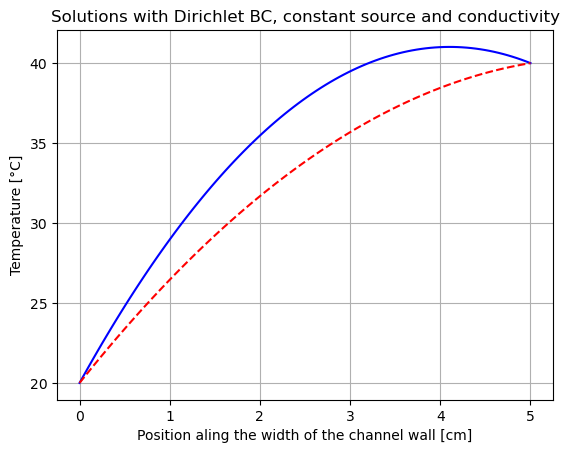

In [29]:
plot_func(lambda x: u_star(x, phi_list, lift_func, c_star_vec), x_min, x_max, 100,
          x_scale=100,
          title='Solutions with Dirichlet BC, constant source and conductivity', 
          xlabel='Position aling the width of the channel wall [cm]',
          ylabel='Temperature [°C]', gold_data=u_gold)

In [30]:
import numpy as np
(x,u,q) = np.loadtxt('gold-data/01-test-gold.txt')
u_gold_2 = np.column_stack((x,q))

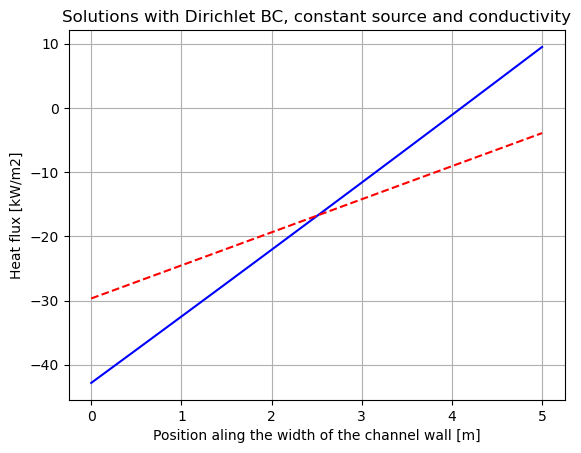

In [31]:
h_e = (x_max-x_min)/n_elem
q_x = lambda x: - k_func(x) * u_star_prime(x, phi_prime_list, lift_func_prime, c_star_vec, h_e)
plot_func(q_x, x_min, x_max, 100, 
          x_scale=100, y_scale=1/1000,
          title='Solutions with Dirichlet BC, constant source and conductivity', 
          xlabel='Position aling the width of the channel wall [m]',
          ylabel='Heat flux [kW/m2]', gold_data = u_gold_2)

### [Results Comparison with a Analytical Solution](#toc)<a id = "Analytical"></a>

## [Conclusion](#toc)<a id = "Conclusion"></a>